# Perform XGBoost

___

# Import library and Data Setup
Import necessary library

**Setup the training data and testing data set**

The train.csv and test.csv were split using [export_train_test_set.ipynb](https://github.com/cmxteng/aiforsea-traffic-management/blob/master/export_train_test_set.ipynb) 

It is split into test dataset (day 48 to day 61) and train dataset (day 1 to day 47).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

### Get the Data

**Read in the training csv file and Hold-out test csv file as a DataFrame called trainset and testset respectively.**

In [64]:
trainset = pd.read_csv('train47.csv')

In [65]:
testset = pd.read_csv('test14.csv')

In [66]:
trainset.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [67]:
testset.head()

,geohash6,day,timestamp,demand
0,qp03nr,51,20:45,0.000293
1,qp093r,48,6:15,0.054170
2,qp03rp,52,11:45,0.359406
3,qp03mf,48,11:30,0.057255
4,qp091w,56,10:0,0.008772


In [68]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213492 entries, 0 to 3213491
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 98.1+ MB


In [69]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992829 entries, 0 to 992828
Data columns (total 4 columns):
geohash6     992829 non-null object
day          992829 non-null int64
timestamp    992829 non-null object
demand       992829 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 30.3+ MB


### Convert timestamp to time (in hour format) in float
* 15 minute: 0.25 hour
* 30 minute: 0.50 hour
* 45 minute: 0.75 hour

In [70]:
# extract hour and minute from timestamp column for trainset
trainset[['hour','min']] = trainset['timestamp'].str.split(':',expand=True).astype('int64')
trainset['time'] = trainset['hour']+(trainset['min']/60.0)

In [71]:
# extract hour and minute from timestamp column for testset
testset[['hour','min']] = testset['timestamp'].str.split(':',expand=True).astype('int64')
testset['time'] = testset['hour']+(testset['min']/60.0)

### Decode Geohash6

In [72]:
import geohash

In [73]:
trainset['coordinate'] = trainset.geohash6.apply(lambda c: geohash.decode(c))

trainset['coordinate'].tolist()
trainset[['latitude', 'longitude']] = pd.DataFrame(trainset['coordinate'].tolist(), index=trainset.index)

In [74]:
testset['coordinate'] = testset.geohash6.apply(lambda c: geohash.decode(c))

testset['coordinate'].tolist()
testset[['latitude', 'longitude']] = pd.DataFrame(testset['coordinate'].tolist(), index=testset.index)

## Setting up the Train Test Data

**Get data ready for the regression models.**


Check data info again

In [75]:
X_train = trainset[['time','day','latitude','longitude']].values
y_train = trainset['demand'].values

In [76]:
X_test = testset[['time','day','latitude','longitude']].values
y_test = testset['demand'].values

In [77]:
print(X_train.shape)
print(y_train.shape)

(3213492, 4)
(3213492,)


In [78]:
print(X_test.shape)
print(y_test.shape)

(992829, 4)
(992829,)


___

## eXtreme Gradient Boost - XGBoost model

### Train the XGBoost model

To start, import the XGBoost library and neccessary library. 

In [17]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

### The best parameters from tuning are:
* gamma = 0
* min_child_weight = 5
* max_depth = 60
* subsample = 0.6
* colsample_bytree = 0.8
* learning_rate = 0.1
* n_estimators = 200
* reg_alpha = 0.2


In [18]:
xgb9 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=200,
                    #nthread=4,
                    n_jobs=-1,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27)

In [79]:
xgb9.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=60,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.2,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6, tree_method='exact')

### Cross Validation for new optimum parameter of XGBoost model
This is to test performance and overfitting using k-fold validation; here we take 10 folds, cv = 10.

In [82]:
scores_xgb = cross_val_score(xgb9, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [85]:
print('Scores for k=10 fold validation:',scores_xgb)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb.mean())))

Scores for k=10 fold validation: [-0.00162364 -0.00162825 -0.00161762 -0.00161994 -0.00163636 -0.0016164
 -0.00161113 -0.0016307  -0.00160542 -0.00162237]
Train MSE: -0.001621 (+/- 0.000017)
Train RMSE: 0.040264


### Prediction for test dataset

In [80]:
xgb9_score = xgb9.score(X_test, y_test)
print("Prediction Score: %0.6f" % xgb9_score)

Prediction Score: 0.772564


In [81]:
# Predicting a rgb result
xgb9_pred = xgb9.predict(X_test)
from sklearn import metrics
print('Test MAE:', metrics.mean_absolute_error(y_test, xgb9_pred))
print('Test MSE:', metrics.mean_squared_error(y_test, xgb9_pred))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb9_pred)))

Test MAE: 0.04616363849202744
Test MSE: 0.006378613001421889
Test RMSE: 0.07986621940108277


The cross validation of test RMSE value is close to train RMSE.

| Models                 | XGBoost |
|------------------------|---------|
|CV Train RMSE:          | 0.0403  |
|Prediction RMSE:        | 0.0799  |


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

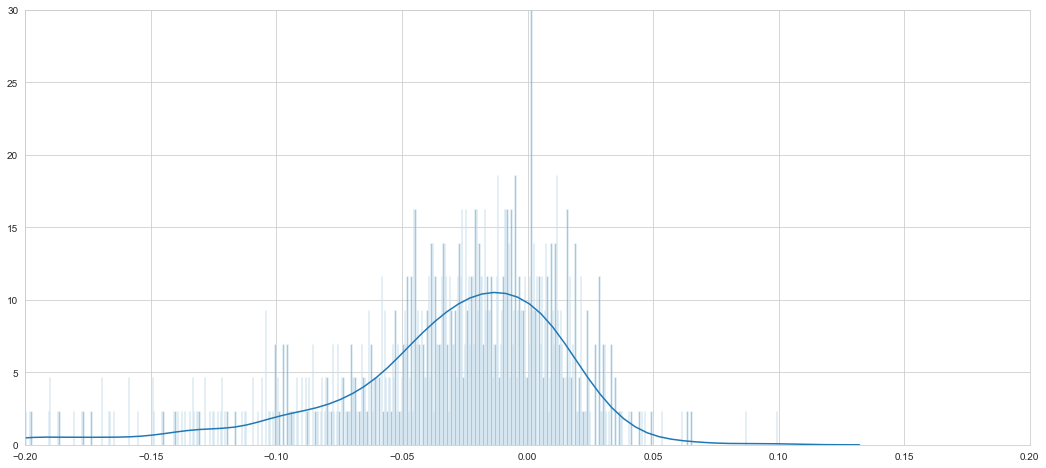

In [63]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-xgb9_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

### Visualize the features importance
There are features included: 
1. time, f0
2. day, f1
3. latitude, f2
4. longtude, f3

The result shows **time is the most important feature**.

In [21]:
print(xgb9.feature_importances_)

[0.35384938 0.26246685 0.20399931 0.17968445]


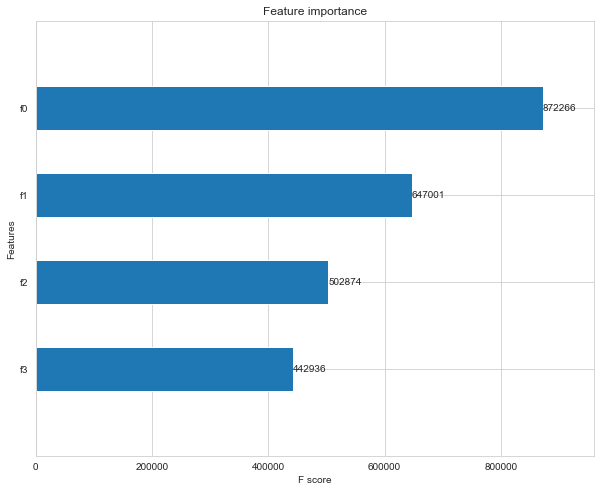

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
xgb.plot_importance(xgb9, height=0.5, ax=ax)
plt.show()

___